<a href="https://colab.research.google.com/github/itee26/fintech_project/blob/main/proj_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
def ema(price, window):
    return price['Close'].ewm(span=window, adjust=False).mean()

In [ ]:
def rsi(price, window):
 closing_price=price['Close'].diff(1)
 gain=closing_price.where(closing_price>0,0)
 loss=-closing_price.where(closing_price<0,0)
 avg_gain=gain.rolling(window=14).mean()
 avg_loss=loss.rolling(window=14).mean()
 rs=avg_gain/avg_loss
 rsi=100-(100/(1+rs))
 return rsi

In [ ]:
def signals(price, ema_window, rsi_window, rsi_overbought, rsi_oversold):
    signals = pd.DataFrame(index=price.index)
    signals['EMA'] = ema(price, ema_window)
    signals['RSI'] = rsi(price, rsi_window)
    signals['Signal'] = 0
    signals['Signal'][signals['EMA'] > price['Close']] = 1  # Long signal
    signals['Signal'][signals['EMA'] < price['Close']] = -1  # Short signal
    signals['Signal'][(signals['RSI'] > rsi_overbought) & (signals['Signal'] == 1)] = 0  # Exit long
    signals['Signal'][(signals['RSI'] < rsi_oversold) & (signals['Signal'] == -1)] = 0  # Exit short
    return signals

In [ ]:
ticker='TCS.NS'
start='2019-01-28'
end='2024-01-24'
price=yf.download(ticker,start=start,end=end)
ema_window=20
rsi_window=14
rsi_overbought=70
rsi_oversold=30
signals=signals(price,ema_window,rsi_window,rsi_overbought,rsi_oversold)
print(signals)

[*********************100%%**********************]  1 of 1 completed

                    EMA        RSI  Signal
Date                                      
2019-01-28  1955.000000        NaN       0
2019-01-29  1957.642857        NaN      -1
2019-01-30  1959.905445        NaN      -1
2019-01-31  1965.066828        NaN      -1
2019-02-01  1971.246173        NaN      -1
...                 ...        ...     ...
2024-01-17  3771.828797  57.171905      -1
2024-01-18  3784.283207  59.069784      -1
2024-01-19  3799.403858  60.560224      -1
2024-01-22  3813.084448  63.391154      -1
2024-01-23  3817.385929  64.105395      -1

[1233 rows x 3 columns]



<ipython-input-69-a0b8c491f3c8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['Signal'][signals['EMA'] > price['Close']] = 1  # Long signal
<ipython-input-69-a0b8c491f3c8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['Signal'][signals['EMA'] < price['Close']] = -1  # Short signal
<ipython-input-69-a0b8c491f3c8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['Signal'][(signals['RSI'] > rsi_overbought) &

In [ ]:
def backtest(price,signals,initial_capital=50001,compound=True):
    positions = pd.DataFrame(index=price.index)
    positions['Position'] = signals['Signal']
    positions['Stock'] = 100 * positions['Position'] #assuming 100 shares
    portfolio = positions.multiply(price['Close'], axis=0)
    pos_diff = positions.diff()
    portfolio['Cash'] = initial_capital - (pos_diff['Stock'] * price['Close']).cumsum()
    portfolio['Total'] = portfolio['Stock'] + portfolio['Cash']
    portfolio['Returns'] = portfolio['Total'].pct_change()
    if compound:
        portfolio['Returns'] = (1 + portfolio['Returns']).cumprod() - 1
    return portfolio


In [ ]:
portfolio=backtest(price,signals)
print(portfolio)

               Position          Stock           Cash         Total   Returns
Date                                                                         
2019-01-28     0.000000       0.000000            NaN           NaN       NaN
2019-01-29 -1982.750000 -198275.000000  248276.000000  50001.000000       NaN
2019-01-30 -1981.400024 -198140.002441  248276.000000  50135.997559  0.002700
2019-01-31 -2014.099976 -201409.997559  248276.000000  46866.002441 -0.062699
2019-02-01 -2029.949951 -202994.995117  248276.000000  45281.004883 -0.094398
...                 ...            ...            ...           ...       ...
2024-01-17 -3884.600098 -388460.009766  477931.004883  89470.995117  0.789384
2024-01-18 -3902.600098 -390260.009766  477931.004883  87670.995117  0.753385
2024-01-19 -3943.050049 -394305.004883  477931.004883  83626.000000  0.672487
2024-01-22 -3943.050049 -394305.004883  477931.004883  83626.000000  0.672487
2024-01-23 -3858.250000 -385825.000000  477931.004883  92106.004

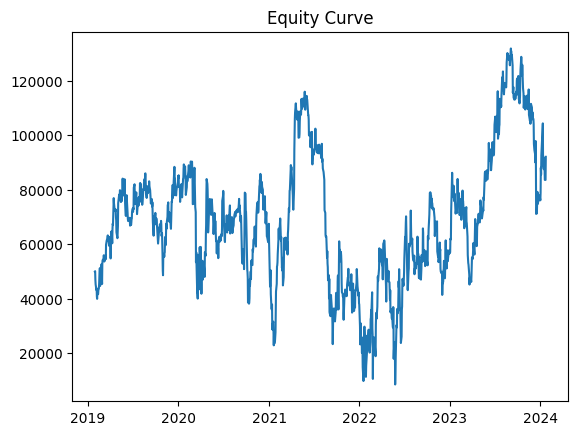

In [ ]:
plt.plot(portfolio['Total'])
plt.title(label='Equity Curve')
plt.show()

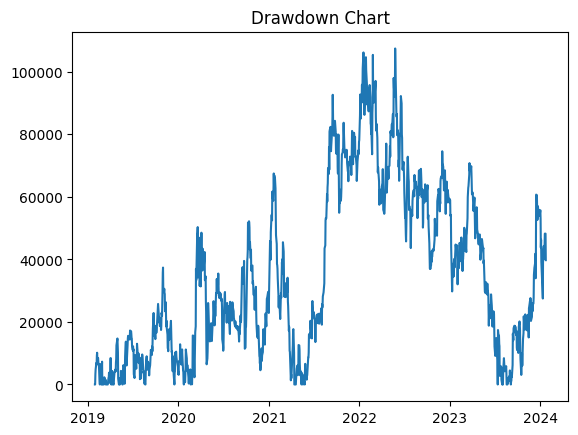

In [ ]:
plt.plot(portfolio['Total'].cummax() - portfolio['Total'])
plt.title(label='Drawdown Chart')
plt.show()

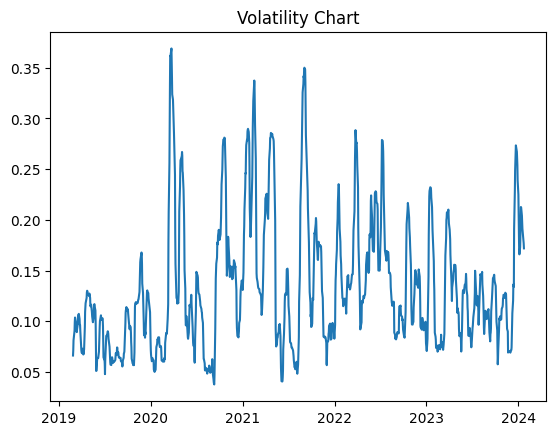

In [ ]:
plt.plot(portfolio['Returns'].rolling(window=20).std())
plt.title(label='Volatility Chart')
plt.show()